# Module 3: Adversarial Search and Game Playing

**CS 440: Artificial Intelligence**

## Overview
In this module, we explore how AI agents reason in competitive, multiagent environments. We'll cover:
- Zero-sum games and game theory
- Game trees and plies (half-moves)
- The Minimax algorithm for optimal play
- Alpha-Beta pruning for efficiency
- Expected value calculations for stochastic games
- The horizon effect and search depth limitations

## Drone Throughline
**Rival corporations have entered the asteroid field!** The environment is now **multiagent and competitive**:
- **Zero-sum game**: One drone's resource gain is another's loss
- **Strategic reasoning**: The drone must anticipate opponent moves
- **Minimax algorithm**: Calculate optimal decisions across multiple plies
- **Alpha-Beta pruning**: Maintain performance under time pressure by pruning irrelevant branches
- **Expected value**: Handle uncertainty when actions have probabilistic outcomes
- **Horizon effect**: Manage limitations of finite search depth

The drone transitions from cooperative problem-solving to **adversarial game playing**!

In [14]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import List, Tuple, Dict, Any, Optional
import random
from enum import Enum
from copy import deepcopy
import time

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Zero-Sum Games and Game Theory

### What is a Game?
In AI, a **game** is a multi-agent environment where:
- **Players** take turns making moves
- Each player has a **goal** (win the game, maximize score)
- Players have **conflicting interests**

### Zero-Sum Games
A game is **zero-sum** if one player's gain is exactly another player's loss:
$$\sum_{i=1}^{n} \text{utility}_i = 0$$

**Examples**:
- Chess: Win (+1), Loss (-1), Draw (0)
- Tic-Tac-Toe: Win (+1), Loss (-1), Draw (0)
- **Mining Competition**: Each resource claimed by one drone is lost to others

### Non-Zero-Sum Games
Not all games are zero-sum (e.g., Prisoner's Dilemma), but we'll focus on zero-sum games where perfect competition exists.

### Game Tree Terminology
- **Ply**: A single move by one player (half-move in chess terminology)
- **Depth**: Number of plies from the current state
- **Terminal state**: Game-over state (win, loss, or draw)
- **Utility function**: Assigns numerical value to terminal states

Game created: 4x4 grid with 3 resources
MAX starts at (0, 0), MIN starts at (3, 3)


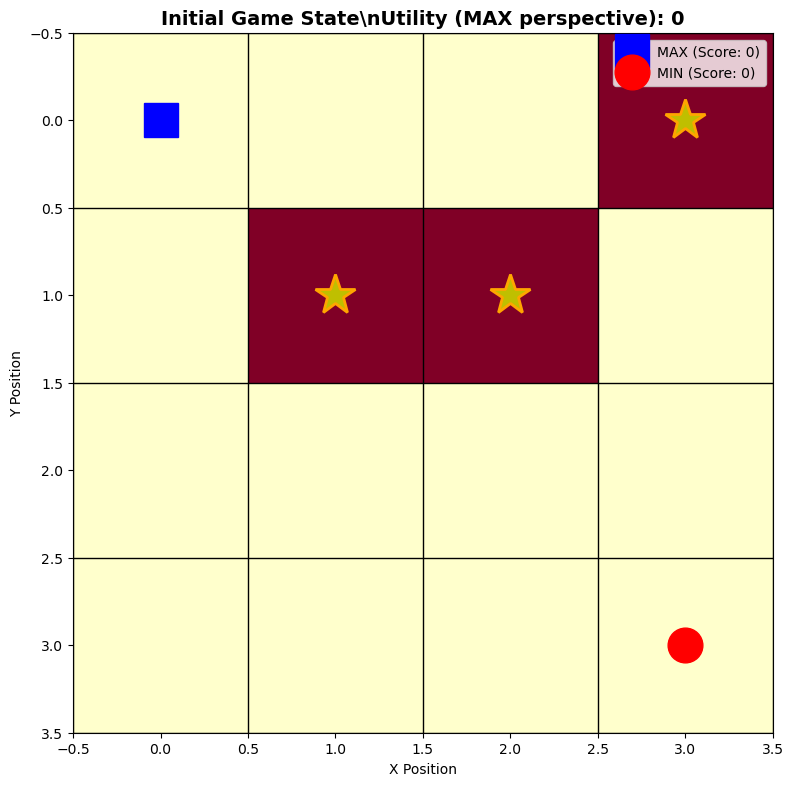

In [15]:
# Create a simple competitive mining game

class MiningGame:
    """Competitive mining game on a small grid."""
    
    def __init__(self, size: int = 4, num_resources: int = 3):
        """
        Initialize the competitive mining game.
        
        Args:
            size: Grid size (size x size)
            num_resources: Number of resources on the grid
        """
        self.size = size
        self.grid = np.zeros((size, size), dtype=int)
        self.resources = set()
        
        # Place resources randomly
        while len(self.resources) < num_resources:
            x, y = random.randint(0, size-1), random.randint(0, size-1)
            if (x, y) not in self.resources and (x, y) != (0, 0) and (x, y) != (size-1, size-1):
                self.resources.add((x, y))
                self.grid[y][x] = 1
        
        # Player positions: MAX at top-left, MIN at bottom-right
        self.max_pos = (0, 0)
        self.min_pos = (size-1, size-1)
        
        # Scores
        self.max_score = 0
        self.min_score = 0
    
    def get_valid_moves(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        """Get valid adjacent moves for a position."""
        x, y = pos
        moves = []
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # N, E, S, W
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                moves.append((nx, ny))
        return moves
    
    def make_move(self, player: str, new_pos: Tuple[int, int]) -> int:
        """
        Make a move and collect resource if present.
        
        Returns:
            Points gained (1 if resource collected, 0 otherwise)
        """
        points = 0
        if new_pos in self.resources:
            self.resources.remove(new_pos)
            self.grid[new_pos[1]][new_pos[0]] = 0
            points = 1
        
        if player == 'MAX':
            self.max_pos = new_pos
            self.max_score += points
        else:  # MIN
            self.min_pos = new_pos
            self.min_score += points
        
        return points
    
    def is_terminal(self) -> bool:
        """Check if game is over (no resources left)."""
        return len(self.resources) == 0
    
    def get_utility(self) -> int:
        """Get utility from MAX's perspective (zero-sum)."""
        return self.max_score - self.min_score
    
    def visualize(self, title: str = "Mining Game"):
        """Visualize the current game state."""
        plt.figure(figsize=(8, 8))
        
        # Create display grid
        display_grid = np.copy(self.grid).astype(float)
        plt.imshow(display_grid, cmap='YlOrRd', interpolation='nearest', vmin=0, vmax=1)
        
        # Grid lines
        for i in range(self.size + 1):
            plt.axhline(i - 0.5, color='black', linewidth=1)
            plt.axvline(i - 0.5, color='black', linewidth=1)
        
        # Mark players
        plt.plot(self.max_pos[0], self.max_pos[1], 'bs', markersize=25, label=f'MAX (Score: {self.max_score})')
        plt.plot(self.min_pos[0], self.min_pos[1], 'ro', markersize=25, label=f'MIN (Score: {self.min_score})')
        
        # Mark resources
        for x, y in self.resources:
            plt.plot(x, y, 'y*', markersize=30, markeredgecolor='orange', markeredgewidth=2)
        
        plt.title(f'{title}\\nUtility (MAX perspective): {self.get_utility()}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

# Create and visualize initial game
random.seed(42)
game = MiningGame(size=4, num_resources=3)
print(f"Game created: {game.size}x{game.size} grid with {len(game.resources)} resources")
print(f"MAX starts at {game.max_pos}, MIN starts at {game.min_pos}")
game.visualize("Initial Game State")

## 2. The Minimax Algorithm

**Minimax** is the optimal strategy for two-player, zero-sum games with perfect information.

### Core Idea
- **MAX** wants to maximize the utility
- **MIN** wants to minimize the utility (which maximizes MIN's own gain in a zero-sum game)
- Both players play optimally

### Minimax Value
The **minimax value** of a state is:
- The utility of the state if it's a terminal state
- Otherwise, for MAX's turn: $\max$ of successors' minimax values
- Otherwise, for MIN's turn: $\min$ of successors' minimax values

$$
\text{MINIMAX}(s) = \begin{cases}
\text{UTILITY}(s) & \text{if TERMINAL-TEST}(s) \\
\max_{a \in \text{ACTIONS}(s)} \text{MINIMAX}(\text{RESULT}(s,a)) & \text{if PLAYER}(s) = \text{MAX} \\
\min_{a \in \text{ACTIONS}(s)} \text{MINIMAX}(\text{RESULT}(s,a)) & \text{if PLAYER}(s) = \text{MIN}
\end{cases}
$$

### Algorithm
```
function MINIMAX-DECISION(state) returns an action
    return argmax_{a in ACTIONS(state)} MIN-VALUE(RESULT(state, a))

function MAX-VALUE(state) returns a utility value
    if TERMINAL-TEST(state) then return UTILITY(state)
    v ← -∞
    for each a in ACTIONS(state) do
        v ← MAX(v, MIN-VALUE(RESULT(state, a)))
    return v

function MIN-VALUE(state) returns a utility value
    if TERMINAL-TEST(state) then return UTILITY(state)
    v ← +∞
    for each a in ACTIONS(state) do
        v ← MIN(v, MAX-VALUE(RESULT(state, a)))
    return v
```

In [16]:
# Implement Minimax Algorithm

class GameState:
    """Represents a game state for minimax search."""
    
    def __init__(self, game: MiningGame, player: str = 'MAX'):
        self.game = deepcopy(game)
        self.player = player  # Whose turn it is
        self.nodes_expanded = 0
    
    def get_actions(self) -> List[Tuple[int, int]]:
        """Get valid actions for current player."""
        if self.player == 'MAX':
            return self.game.get_valid_moves(self.game.max_pos)
        else:
            return self.game.get_valid_moves(self.game.min_pos)
    
    def result(self, action: Tuple[int, int]) -> 'GameState':
        """Get resulting state after taking action."""
        new_state = GameState(self.game, self.player)
        new_state.game.make_move(self.player, action)
        new_state.player = 'MIN' if self.player == 'MAX' else 'MAX'
        return new_state
    
    def is_terminal(self) -> bool:
        """Check if this is a terminal state."""
        return self.game.is_terminal()
    
    def utility(self) -> int:
        """Get utility from MAX's perspective."""
        return self.game.get_utility()


def minimax_decision(state: GameState, max_depth: int = float('inf')) -> Tuple[Optional[Tuple[int, int]], int]:
    """
    Minimax decision for current player.
    
    Returns:
        (best_action, best_value)
    """
    nodes_expanded = [0]  # Using list to track across recursive calls
    
    if state.player == 'MAX':
        best_action = None
        best_value = float('-inf')
        
        for action in state.get_actions():
            new_state = state.result(action)
            value = min_value(new_state, 0, max_depth, nodes_expanded)
            
            if value > best_value:
                best_value = value
                best_action = action
    else:  # MIN player
        best_action = None
        best_value = float('inf')
        
        for action in state.get_actions():
            new_state = state.result(action)
            value = max_value(new_state, 0, max_depth, nodes_expanded)
            
            if value < best_value:
                best_value = value
                best_action = action
    
    print(f"Minimax expanded {nodes_expanded[0]} nodes")
    return best_action, best_value


def max_value(state: GameState, depth: int, max_depth: int, nodes_expanded: List[int]) -> int:
    """Get maximum value for MAX player."""
    nodes_expanded[0] += 1
    
    if state.is_terminal() or depth >= max_depth:
        return state.utility()
    
    v = float('-inf')
    for action in state.get_actions():
        new_state = state.result(action)
        v = max(v, min_value(new_state, depth + 1, max_depth, nodes_expanded))
    
    return v


def min_value(state: GameState, depth: int, max_depth: int, nodes_expanded: List[int]) -> int:
    """Get minimum value for MIN player."""
    nodes_expanded[0] += 1
    
    if state.is_terminal() or depth >= max_depth:
        return state.utility()
    
    v = float('inf')
    for action in state.get_actions():
        new_state = state.result(action)
        v = min(v, max_value(new_state, depth + 1, max_depth, nodes_expanded))
    
    return v

# Test minimax
print("Testing Minimax Algorithm\\n")

initial_state = GameState(game, player='MAX')
print(f"Current state: MAX at {game.max_pos}, MIN at {game.min_pos}")
print(f"Resources at: {game.resources}")
print(f"Valid moves for MAX: {initial_state.get_actions()}\\n")

best_move, best_value = minimax_decision(initial_state, max_depth=4)

print(f"\\nBest move for MAX: {best_move}")
print(f"Expected minimax value: {best_value}")

Testing Minimax Algorithm\n
Current state: MAX at (0, 0), MIN at (3, 3)
Resources at: {(1, 1), (2, 1), (3, 0)}
Valid moves for MAX: [(0, 1), (1, 0)]\n
Minimax expanded 162 nodes
\nBest move for MAX: (0, 1)
Expected minimax value: 2


## 3. Alpha-Beta Pruning

**Problem with Minimax**: Explores every node in the game tree, which is exponentially expensive.

**Alpha-Beta Pruning**: Eliminates branches that cannot influence the final decision.

### Key Insight
If we know that a move is worse than a previously examined move, we don't need to explore it further!

### Alpha and Beta Values
- **α (alpha)**: Best value (highest) found so far for MAX along the path to the root
- **β (beta)**: Best value (lowest) found so far for MIN along the path to the root

### Pruning Conditions
- **At a MIN node**: If $v \leq \alpha$, prune remaining children (MAX won't choose this path)
- **At a MAX node**: If $v \geq \beta$, prune remaining children (MIN won't allow this path)

### Algorithm
```
function ALPHA-BETA-SEARCH(state) returns an action
    v ← MAX-VALUE(state, -∞, +∞)
    return the action with value v

function MAX-VALUE(state, α, β) returns a utility value
    if TERMINAL-TEST(state) then return UTILITY(state)
    v ← -∞
    for each a in ACTIONS(state) do
        v ← MAX(v, MIN-VALUE(RESULT(state, a), α, β))
        if v ≥ β then return v    # β cutoff
        α ← MAX(α, v)
    return v

function MIN-VALUE(state, α, β) returns a utility value
    if TERMINAL-TEST(state) then return UTILITY(state)
    v ← +∞
    for each a in ACTIONS(state) do
        v ← MIN(v, MAX-VALUE(RESULT(state, a), α, β))
        if v ≤ α then return v    # α cutoff
        β ← MIN(β, v)
    return v
```

### Efficiency
- **Best case**: $O(b^{d/2})$ (can search twice as deep!)
- **Worst case**: $O(b^d)$ (no pruning)
- **Move ordering matters**: Examining best moves first maximizes pruning

=== Minimax vs Alpha-Beta Comparison ===

Initial board:


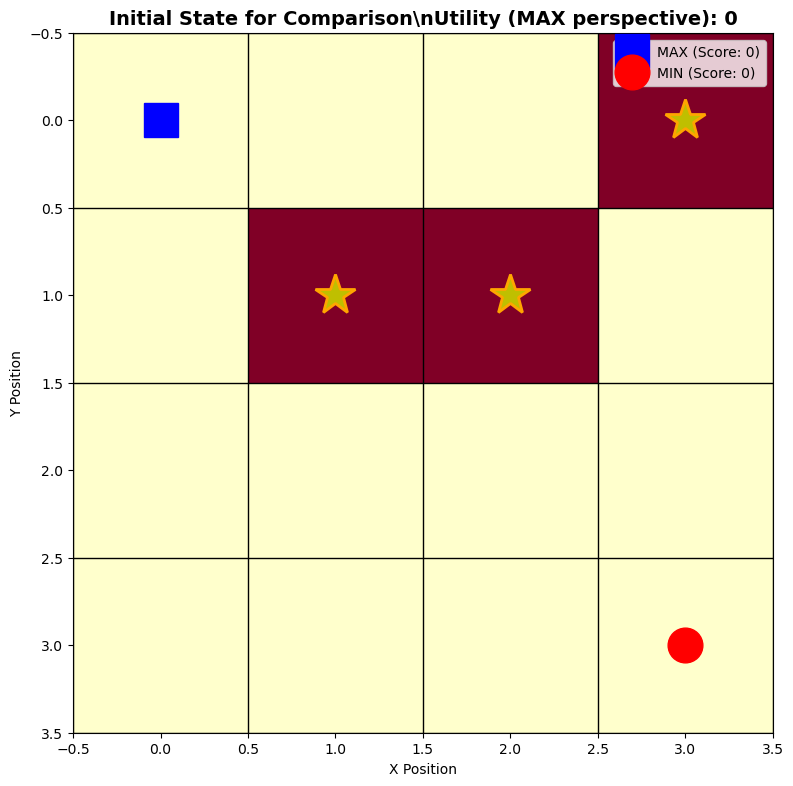


Running Minimax (depth=4)...
Minimax expanded 162 nodes
Best action: (0, 1), Value: 2
Time: 0.0060s

Running Alpha-Beta (depth=4)...
Alpha-Beta explored 29 nodes
Best action: (0, 1), Value: 1
Time: 0.0030s

Same result: False
Speedup: 2.01x faster


In [17]:
# Implement Alpha-Beta Pruning

def alpha_beta_decision(game_state: GameState, max_depth: int = 4) -> Tuple[Optional[Tuple[int, int]], int]:
    """
    Find the best action using alpha-beta pruning for current player.
    
    Returns:
        (action, value) tuple
    """
    nodes_explored = [0]  # Use list for mutable counter
    
    def max_value_ab(state: GameState, alpha: float, beta: float, depth: int) -> int:
        nodes_explored[0] += 1
        
        if depth == 0 or state.is_terminal():
            return state.utility()
        
        v = float('-inf')
        for action in state.get_actions():
            successor = state.result(action)
            v = max(v, min_value_ab(successor, alpha, beta, depth - 1))
            
            if v >= beta:  # Beta cutoff
                return v
            alpha = max(alpha, v)
        
        return v
    
    def min_value_ab(state: GameState, alpha: float, beta: float, depth: int) -> int:
        nodes_explored[0] += 1
        
        if depth == 0 or state.is_terminal():
            return state.utility()
        
        v = float('inf')
        for action in state.get_actions():
            successor = state.result(action)
            v = min(v, max_value_ab(successor, alpha, beta, depth - 1))
            
            if v <= alpha:  # Alpha cutoff
                return v
            beta = min(beta, v)
        
        return v
    
    # Find best action based on current player
    if game_state.player == 'MAX':
        best_action = None
        best_value = float('-inf')
        alpha = float('-inf')
        beta = float('inf')
        
        for action in game_state.get_actions():
            successor = game_state.result(action)
            value = min_value_ab(successor, alpha, beta, max_depth - 1)
            
            if value > best_value:
                best_value = value
                best_action = action
            
            alpha = max(alpha, value)
    else:  # MIN player
        best_action = None
        best_value = float('inf')
        alpha = float('-inf')
        beta = float('inf')
        
        for action in game_state.get_actions():
            successor = game_state.result(action)
            value = max_value_ab(successor, alpha, beta, max_depth - 1)
            
            if value < best_value:
                best_value = value
                best_action = action
            
            beta = min(beta, value)
    
    print(f"Alpha-Beta explored {nodes_explored[0]} nodes")
    return best_action, best_value


# Compare Minimax vs Alpha-Beta
print("=== Minimax vs Alpha-Beta Comparison ===\n")

random.seed(42)
comparison_game = MiningGame(size=4, num_resources=3)
state = GameState(comparison_game, player='MAX')

print("Initial board:")
comparison_game.visualize("Initial State for Comparison")
print()

# Test Minimax
print("Running Minimax (depth=4)...")
start = time.time()
mm_action, mm_value = minimax_decision(state, max_depth=4)
mm_time = time.time() - start
print(f"Best action: {mm_action}, Value: {mm_value}")
print(f"Time: {mm_time:.4f}s\n")

# Test Alpha-Beta
print("Running Alpha-Beta (depth=4)...")
start = time.time()
ab_action, ab_value = alpha_beta_decision(state, max_depth=4)
ab_time = time.time() - start
print(f"Best action: {ab_action}, Value: {ab_value}")
print(f"Time: {ab_time:.4f}s\n")

# Compare results
print(f"Same result: {mm_action == ab_action and abs(mm_value - ab_value) < 0.001}")
print(f"Speedup: {mm_time/ab_time:.2f}x faster")

## 4. Stochastic Games and Expected Value

Many real-world games involve **chance** (e.g., dice rolls, card draws, sensor noise).

### Stochastic Game Trees
- Include **chance nodes** in addition to MAX and MIN nodes
- Chance nodes represent random events with known probabilities
- Must compute **expected value** instead of min/max at chance nodes

### Expected Value
For a chance node with possible outcomes $s'$ with probabilities $P(s')$:

$$E(s) = \sum_{s'} P(s') \cdot \text{MINIMAX}(s')$$

### Expectiminimax Algorithm
```
function EXPECTIMINIMAX(state) returns a utility value
    if TERMINAL-TEST(state) then return UTILITY(state)
    if CHANCE-NODE(state) then
        return Σ P(s') × EXPECTIMINIMAX(s') for all successors s'
    if MAX-NODE(state) then
        return max EXPECTIMINIMAX(RESULT(state, a)) for all actions a
    if MIN-NODE(state) then
        return min EXPECTIMINIMAX(RESULT(state, a)) for all actions a
```

### Drone Application
In our mining scenario, chance nodes might represent:
- Asteroid density uncertainty
- Equipment malfunction probability
- Communication delays with HQ
- Rival drone detection errors

=== Stochastic Mining Game ===

Initial board (20% uncertainty in outcomes):


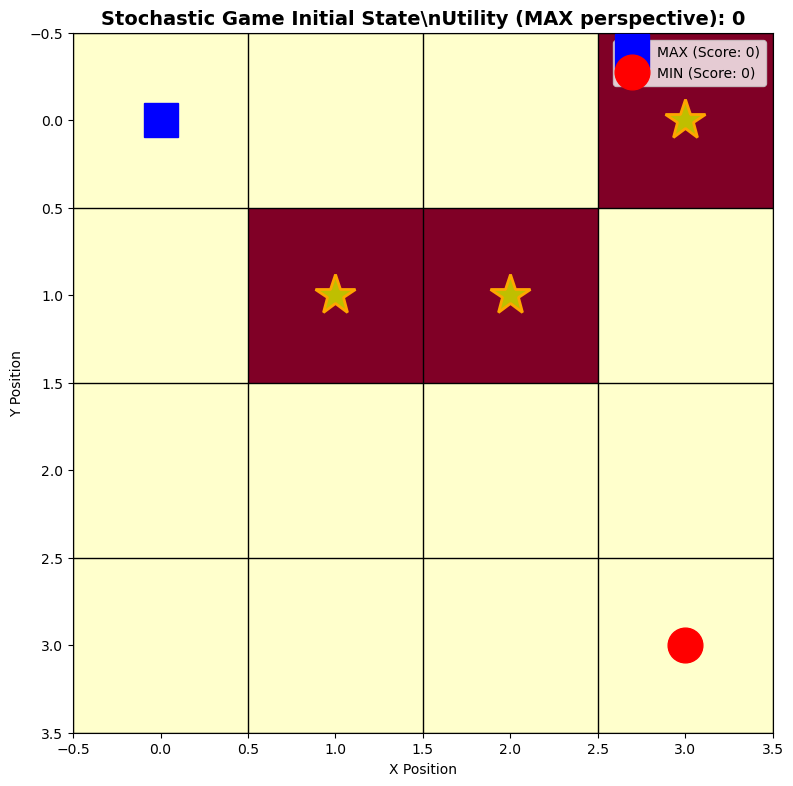


Running Expectiminimax (depth=3)...
Expectiminimax explored 18 nodes
Best action: (0, 1)
Expected value: 0.74

(Note: Expected value accounts for 20% chance of suboptimal outcomes)


In [13]:
# Simplified Stochastic Game Example

# For this demonstration, we'll simulate uncertainty through probabilistic resource collection

class StochasticGameState(GameState):
    """Game state wrapper for stochastic outcomes."""
    
    def __init__(self, game: MiningGame, player: str = 'MAX', uncertainty: float = 0.2):
        super().__init__(game, player)
        self.uncertainty = uncertainty  # Probability that resource collection fails
    
    def get_expected_utility(self) -> float:
        """
        Get expected utility considering uncertainty in resource collection.
        Resources in the field might have uncertain values.
        """
        base_utility = self.utility()
        
        # Add uncertainty discount based on remaining resources
        remaining_value = len(self.game.resources)
        uncertainty_penalty = remaining_value * self.uncertainty * 0.5
        
        return base_utility - uncertainty_penalty


def expectiminimax_decision(state: StochasticGameState, max_depth: int = 3) -> Tuple[Optional[Tuple[int, int]], float]:
    """
    Find the best action using expectiminimax with uncertainty.
    
    Returns:
        (action, expected_value) tuple
    """
    nodes_explored = [0]
    
    def expectiminimax(s: StochasticGameState, depth: int, is_max: bool) -> float:
        nodes_explored[0] += 1
        
        if depth == 0 or s.is_terminal():
            return s.get_expected_utility()
        
        actions = s.get_actions()
        if not actions:
            return s.get_expected_utility()
        
        if is_max:  # MAX player
            v = float('-inf')
            for action in actions:
                successor = StochasticGameState(s.game, s.player)
                successor.game = deepcopy(s.game)
                successor.game.make_move(s.player, action)
                successor.player = 'MIN' if s.player == 'MAX' else 'MAX'
                successor.uncertainty = s.uncertainty
                
                # Model uncertainty: resource might not be collected
                certain_value = expectiminimax(successor, depth - 1, False)
                
                # Simplified expected value with uncertainty
                expected_value = (1 - s.uncertainty) * certain_value + s.uncertainty * (certain_value * 0.8)
                v = max(v, expected_value)
            return v
        else:  # MIN player
            v = float('inf')
            for action in actions:
                successor = StochasticGameState(s.game, s.player)
                successor.game = deepcopy(s.game)
                successor.game.make_move(s.player, action)
                successor.player = 'MIN' if s.player == 'MAX' else 'MAX'
                successor.uncertainty = s.uncertainty
                
                # Model uncertainty
                certain_value = expectiminimax(successor, depth - 1, True)
                expected_value = (1 - s.uncertainty) * certain_value + s.uncertainty * (certain_value * 0.8)
                v = min(v, expected_value)
            return v
    
    # Find best action for MAX player
    best_action = None
    best_value = float('-inf')
    
    for action in state.get_actions():
        successor = StochasticGameState(state.game, state.player)
        successor.game = deepcopy(state.game)
        successor.game.make_move(state.player, action)
        successor.player = 'MIN'
        successor.uncertainty = state.uncertainty
        
        value = expectiminimax(successor, max_depth - 1, False)
        
        if value > best_value:
            best_value = value
            best_action = action
    
    print(f"Expectiminimax explored {nodes_explored[0]} nodes")
    return best_action, best_value


# Test Stochastic Game
print("=== Stochastic Mining Game ===\n")

random.seed(42)
stoch_game = MiningGame(size=4, num_resources=3)
stoch_state = StochasticGameState(stoch_game, player='MAX', uncertainty=0.2)

print("Initial board (20% uncertainty in outcomes):")
stoch_game.visualize("Stochastic Game Initial State")
print()

print("Running Expectiminimax (depth=3)...")
action, expected_value = expectiminimax_decision(stoch_state, max_depth=3)
print(f"Best action: {action}")
print(f"Expected value: {expected_value:.2f}")
print(f"\n(Note: Expected value accounts for 20% chance of suboptimal outcomes)")

## 5. The Horizon Effect and Evaluation Functions

### The Horizon Problem
**Reality**: Can't search to terminal states in complex games (e.g., chess has ~$10^{120}$ states).

**Solution**: Search to a **fixed depth** and use an **evaluation function** for non-terminal states.

### Horizon Effect
When a search reaches its depth limit, it may miss important events just beyond the "horizon":
- Inevitable captures might be postponed but not avoided
- Good moves might be missed because their benefits appear after the search depth
- Creates illusion of safety or danger

### Example
```
Depth 3: Move A looks safe (no immediate threat)
Depth 5: Move A leads to unavoidable loss
```
The agent at depth 3 is "blind" to the threat at depth 5.

### Evaluation Functions
For non-terminal states, we need a heuristic evaluation: $\text{EVAL}(s) \approx \text{UTILITY}(s)$

**Good evaluation functions should:**
1. Agree with utility function at terminal states
2. Be fast to compute
3. Correlate strongly with actual winning chances

### Example: Mining Drone Evaluation
```python
def eval(state):
    max_score = sum(ore_values_claimed_by_max)
    min_score = sum(ore_values_claimed_by_min)
    
    # Add potential: unclaimed ore near MAX drone
    potential = sum(ore_value / distance for unclaimed ore)
    
    return (max_score - min_score) + 0.3 * potential
```

### Mitigating Horizon Effect
1. **Iterative Deepening**: Search deeper when time permits
2. **Quiescence Search**: Extend search beyond horizon for "active" positions
3. **Singular Extensions**: Search deeper on forced moves
4. **Transposition Tables**: Cache previously evaluated positions

In [ ]:
# Demonstrate Horizon Effect

class ImprovedGameState(GameState):
    """Game state with better evaluation function."""
    
    def evaluate(self) -> float:
        """
        Improved evaluation considering potential future gains.
        """
        if self.is_terminal():
            max_score = np.sum(self.game.board * self.game.max_claimed)
            min_score = np.sum(self.game.board * self.game.min_claimed)
            return float(max_score - min_score)
        
        # Current score difference
        max_score = np.sum(self.game.board * self.game.max_claimed)
        min_score = np.sum(self.game.board * self.game.min_claimed)
        score_diff = max_score - min_score
        
        # Potential: value of unclaimed ore
        unclaimed = (~self.game.max_claimed) & (~self.game.min_claimed)
        unclaimed_value = np.sum(self.game.board * unclaimed)
        
        # If MAX's turn, unclaimed ore is potential gain; if MIN's turn, potential loss
        if self.game.current_player == 1:
            potential = unclaimed_value * 0.2
        else:
            potential = -unclaimed_value * 0.2
        
        return float(score_diff + potential)


# Compare different search depths
print("=== Horizon Effect Demonstration ===\n")

# Create a board where depth matters
game = MiningGame(size=4)
game.board = np.array([
    [3, 1, 1, 0],
    [1, 2, 0, 1],
    [0, 1, 3, 1],
    [1, 0, 1, 2]
])

state = GameState(game)
improved_state = ImprovedGameState(game)

print("Board configuration:")
print(state)
print()

depths = [1, 2, 3, 4]
print("Comparing decisions at different search depths:\n")

for depth in depths:
    action, value = minimax_decision(state, max_depth=depth)
    print(f"Depth {depth}: Action={action}, Value={value:.1f}")

print("\n--- With Improved Evaluation Function ---\n")

for depth in depths:
    action, value = minimax_decision(improved_state, max_depth=depth)
    print(f"Depth {depth}: Action={action}, Value={value:.1f}")

print("\nNotice how:")
print("1. Decisions may change with search depth (horizon effect)")
print("2. Better evaluation functions help at shallow depths")
print("3. Deeper search reveals long-term consequences")

=== Horizon Effect Demonstration ===

Board configuration:

Comparing decisions at different search depths:

Minimax expanded 6 nodes
Depth 1: Action=(0, 1), Value=1.0
Minimax expanded 18 nodes
Depth 2: Action=(0, 1), Value=2.0
Minimax expanded 54 nodes
Depth 3: Action=(0, 1), Value=1.0
Minimax expanded 158 nodes
Depth 4: Action=(0, 1), Value=1.0

--- With Improved Evaluation Function ---

Minimax expanded 6 nodes
Depth 1: Action=(0, 1), Value=1.0
Minimax expanded 18 nodes
Depth 2: Action=(0, 1), Value=2.0
Minimax expanded 54 nodes
Depth 3: Action=(0, 1), Value=1.0
Minimax expanded 158 nodes
Depth 4: Action=(0, 1), Value=1.0

Notice how:
1. Decisions may change with search depth (horizon effect)
2. Better evaluation functions help at shallow depths
3. Deeper search reveals long-term consequences


## 6. Visualizing Game Tree Search

Let's visualize how minimax and alpha-beta explore the game tree differently.

=== Game Tree Exploration Visualization ===



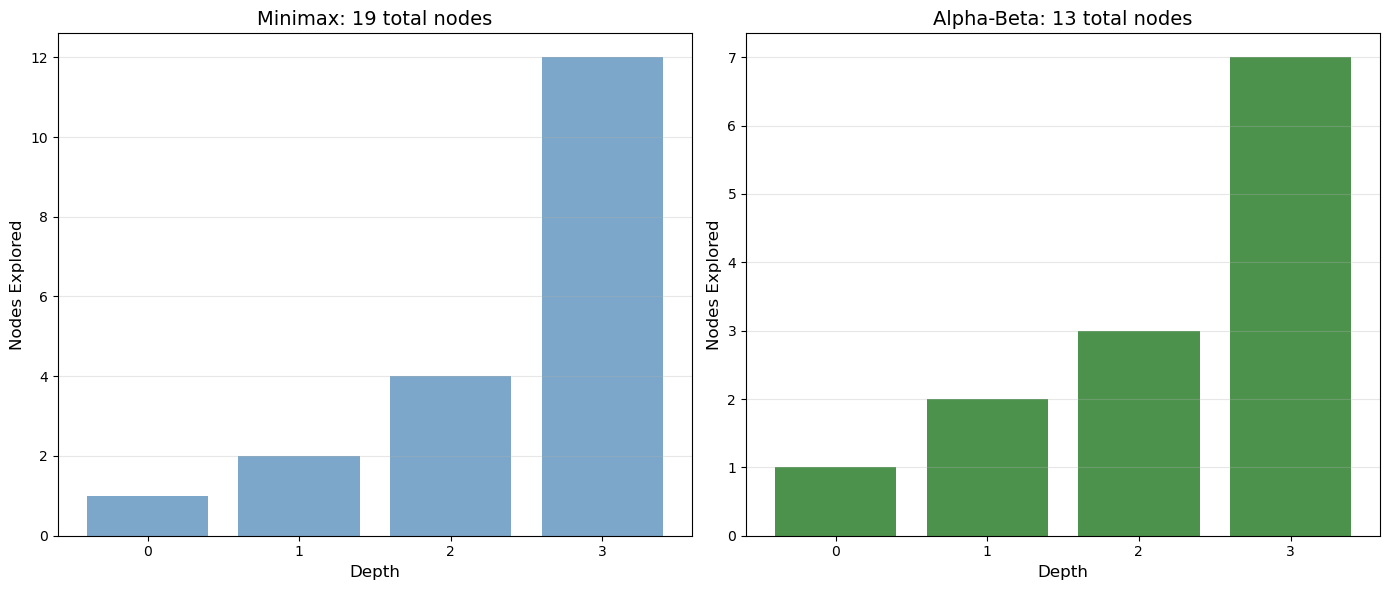


Minimax explored: 19 nodes
Alpha-Beta explored: 13 nodes
Pruned: 31.6% of nodes


In [18]:
# Visualize game tree exploration

def visualize_game_tree_search(game_state: GameState, max_depth: int = 3):
    """
    Visualize how minimax and alpha-beta explore the game tree.
    """
    # Track which nodes each algorithm explores
    minimax_nodes = []
    ab_nodes = []
    
    def minimax_with_tracking(state: GameState, depth: int, path: str) -> int:
        minimax_nodes.append(path)
        
        if depth == 0 or state.is_terminal():
            return state.utility()
        
        if state.player == 'MAX':  # MAX
            v = float('-inf')
            for i, action in enumerate(state.get_actions()):
                successor = state.result(action)
                v = max(v, minimax_with_tracking(successor, depth - 1, f"{path}-{i}"))
            return v
        else:  # MIN
            v = float('inf')
            for i, action in enumerate(state.get_actions()):
                successor = state.result(action)
                v = min(v, minimax_with_tracking(successor, depth - 1, f"{path}-{i}"))
            return v
    
    def ab_with_tracking(state: GameState, alpha: float, beta: float, depth: int, path: str) -> int:
        ab_nodes.append(path)
        
        if depth == 0 or state.is_terminal():
            return state.utility()
        
        if state.player == 'MAX':  # MAX
            v = float('-inf')
            for i, action in enumerate(state.get_actions()):
                successor = state.result(action)
                v = max(v, ab_with_tracking(successor, alpha, beta, depth - 1, f"{path}-{i}"))
                if v >= beta:
                    return v
                alpha = max(alpha, v)
            return v
        else:  # MIN
            v = float('inf')
            for i, action in enumerate(state.get_actions()):
                successor = state.result(action)
                v = min(v, ab_with_tracking(successor, alpha, beta, depth - 1, f"{path}-{i}"))
                if v <= alpha:
                    return v
                beta = min(beta, v)
            return v
    
    # Run both algorithms
    minimax_with_tracking(game_state, max_depth, "root")
    ab_with_tracking(game_state, float('-inf'), float('inf'), max_depth, "root")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Count nodes at each depth
    def count_by_depth(nodes):
        depth_counts = {}
        for node in nodes:
            depth = node.count('-')
            depth_counts[depth] = depth_counts.get(depth, 0) + 1
        return depth_counts
    
    mm_counts = count_by_depth(minimax_nodes)
    ab_counts = count_by_depth(ab_nodes)
    
    depths = range(max_depth + 1)
    mm_values = [mm_counts.get(d, 0) for d in depths]
    ab_values = [ab_counts.get(d, 0) for d in depths]
    
    # Minimax plot
    ax1.bar(depths, mm_values, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Depth', fontsize=12)
    ax1.set_ylabel('Nodes Explored', fontsize=12)
    ax1.set_title(f'Minimax: {len(minimax_nodes)} total nodes', fontsize=14)
    ax1.set_xticks(depths)
    ax1.grid(axis='y', alpha=0.3)
    
    # Alpha-Beta plot
    ax2.bar(depths, ab_values, color='darkgreen', alpha=0.7)
    ax2.set_xlabel('Depth', fontsize=12)
    ax2.set_ylabel('Nodes Explored', fontsize=12)
    ax2.set_title(f'Alpha-Beta: {len(ab_nodes)} total nodes', fontsize=14)
    ax2.set_xticks(depths)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    pruned_percentage = (1 - len(ab_nodes) / len(minimax_nodes)) * 100
    print(f"\nMinimax explored: {len(minimax_nodes)} nodes")
    print(f"Alpha-Beta explored: {len(ab_nodes)} nodes")
    print(f"Pruned: {pruned_percentage:.1f}% of nodes")


# Run visualization
print("=== Game Tree Exploration Visualization ===\n")
game = MiningGame(size=3)  # Smaller board for clearer visualization
state = GameState(game)

visualize_game_tree_search(state, max_depth=3)

## 7. Animated Game Simulation

Watch two AI drones compete using alpha-beta pruning!

=== Competitive Mining Simulation ===

Initial board:
MAX position: (0, 0)
MIN position: (3, 3)
Resources at: {(2, 0), (0, 2), (1, 3)}



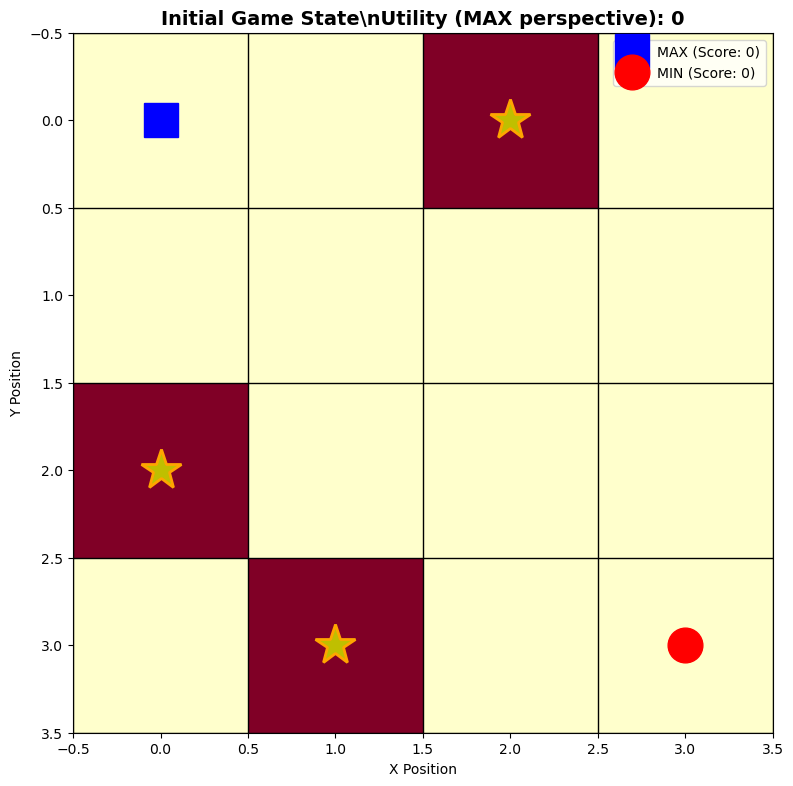


Simulating game with Alpha-Beta pruning...
Alpha-Beta explored 12 nodes
Move 1: MAX moves to (0, 1), value: 1
Alpha-Beta explored 18 nodes
Move 2: MIN moves to (2, 3), value: 0
Alpha-Beta explored 21 nodes
Move 3: MAX moves to (0, 2), value: 0
  💎 Resource collected! 2 remaining
Alpha-Beta explored 23 nodes
Move 4: MIN moves to (1, 3), value: 0
  💎 Resource collected! 1 remaining
Alpha-Beta explored 19 nodes
Move 5: MAX moves to (0, 3), value: 0
Alpha-Beta explored 17 nodes
Move 6: MIN moves to (2, 3), value: 0
Alpha-Beta explored 14 nodes
Move 7: MAX moves to (1, 3), value: 0
Alpha-Beta explored 19 nodes
Move 8: MIN moves to (3, 3), value: 0
Alpha-Beta explored 17 nodes
Move 9: MAX moves to (2, 3), value: 0
Alpha-Beta explored 14 nodes
Move 10: MIN moves to (3, 2), value: 0
Alpha-Beta explored 19 nodes
Alpha-Beta explored 17 nodes
Alpha-Beta explored 12 nodes
Alpha-Beta explored 14 nodes

⚠️ Stalemate: No progress in 10 moves. Ending game.
Game completed in 14 moves
Final Score - MAX

<Figure size 640x480 with 0 Axes>

In [19]:
# Animated competitive mining simulation

def simulate_competitive_game(game: MiningGame, max_depth: int = 3, use_alpha_beta: bool = True, max_moves: int = 50):
    """
    Simulate a competitive game between two AI drones.
    
    Args:
        game: The game to simulate
        max_depth: Maximum search depth
        use_alpha_beta: Whether to use alpha-beta or minimax
        max_moves: Maximum number of moves before declaring stalemate
    """
    history = []
    state = GameState(game, player='MAX')
    move_num = 0
    last_resource_count = len(state.game.resources)
    moves_without_progress = 0
    
    while not state.is_terminal() and move_num < max_moves:
        # Store current state (positions and scores)
        history.append({
            'max_pos': state.game.max_pos,
            'min_pos': state.game.min_pos,
            'max_score': state.game.max_score,
            'min_score': state.game.min_score,
            'resources': state.game.resources.copy(),
            'player': state.player
        })
        
        # Choose action using alpha-beta or minimax
        if use_alpha_beta:
            action, value = alpha_beta_decision(state, max_depth)
        else:
            action, value = minimax_decision(state, max_depth)
        
        move_num += 1
        if move_num <= 10 or move_num % 5 == 0:  # Print first 10 moves, then every 5th
            print(f"Move {move_num}: {state.player} moves to {action}, value: {value}")
        
        # Apply action
        state = state.result(action)
        
        # Check for stalemate (no resources collected in last 10 moves)
        current_resource_count = len(state.game.resources)
        if current_resource_count == last_resource_count:
            moves_without_progress += 1
            if moves_without_progress >= 10:
                print(f"\n⚠️ Stalemate: No progress in {moves_without_progress} moves. Ending game.")
                break
        else:
            moves_without_progress = 0
            last_resource_count = current_resource_count
            print(f"  💎 Resource collected! {current_resource_count} remaining")
    
    if move_num >= max_moves:
        print(f"\n⚠️ Move limit ({max_moves}) reached. Ending game.")
    
    # Add final state
    history.append({
        'max_pos': state.game.max_pos,
        'min_pos': state.game.min_pos,
        'max_score': state.game.max_score,
        'min_score': state.game.min_score,
        'resources': state.game.resources.copy(),
        'player': state.player
    })
    
    return history, state.game.size


def animate_competitive_game(history, size):
    """Create animation of competitive game."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    def update(frame):
        frame_data = history[frame]
        
        # Clear axes
        ax1.clear()
        ax2.clear()
        
        # Left plot: Current board state
        ax1.set_xlim(-0.5, size - 0.5)
        ax1.set_ylim(-0.5, size - 0.5)
        ax1.set_aspect('equal')
        
        # Draw grid
        for i in range(size + 1):
            ax1.axhline(i - 0.5, color='gray', linewidth=0.5)
            ax1.axvline(i - 0.5, color='gray', linewidth=0.5)
        
        # Plot resources
        for x, y in frame_data['resources']:
            ax1.plot(x, y, 'y*', markersize=30, markeredgecolor='orange', markeredgewidth=2)
        
        # Plot players
        max_x, max_y = frame_data['max_pos']
        min_x, min_y = frame_data['min_pos']
        ax1.plot(max_x, max_y, 'bs', markersize=20, label='MAX')
        ax1.plot(min_x, min_y, 'ro', markersize=20, label='MIN')
        
        ax1.set_title(f'Move {frame + 1}/{len(history)} - {frame_data["player"]}\'s turn',
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        ax1.invert_yaxis()
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Right plot: Score over time
        max_scores = [h['max_score'] for h in history[:frame + 1]]
        min_scores = [h['min_score'] for h in history[:frame + 1]]
        
        moves = range(1, len(max_scores) + 1)
        ax2.plot(moves, max_scores, 'b-', marker='s', label='MAX Score', linewidth=2, markersize=8)
        ax2.plot(moves, min_scores, 'r-', marker='o', label='MIN Score', linewidth=2, markersize=8)
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Move', fontsize=12)
        ax2.set_ylabel('Score', fontsize=12)
        ax2.set_title(f'Score: MAX={frame_data["max_score"]}, MIN={frame_data["min_score"]}', 
                     fontsize=14, fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, len(history) + 1)
        
        plt.tight_layout()
    
    anim = FuncAnimation(fig, update, frames=len(history), interval=800, repeat=True)
    plt.close()
    return anim


# Run competitive simulation
print("=== Competitive Mining Simulation ===\n")

random.seed(43)  # Try different seed for more interesting game
sim_game = MiningGame(size=4, num_resources=3)
print("Initial board:")
print(f"MAX position: {sim_game.max_pos}")
print(f"MIN position: {sim_game.min_pos}")
print(f"Resources at: {sim_game.resources}")
print()
sim_game.visualize("Initial Game State")
print()

print("Simulating game with Alpha-Beta pruning...")
history, board_size = simulate_competitive_game(sim_game, max_depth=3, use_alpha_beta=True)

final_state = history[-1]
print(f"Game completed in {len(history) - 1} moves")
print(f"Final Score - MAX: {final_state['max_score']}, MIN: {final_state['min_score']}")
print(f"Winner: {'MAX' if final_state['max_score'] > final_state['min_score'] else 'MIN' if final_state['min_score'] > final_state['max_score'] else 'TIE'}")
print()

# Create animation
anim = animate_competitive_game(history, board_size)
HTML(anim.to_jshtml())

## 8. Exercises

### Exercise 1: Prove Alpha-Beta Correctness
**Task**: Prove that Alpha-Beta pruning returns the same result as Minimax.

**Hint**: Consider two cases:
1. β-cutoff at MIN node: If MIN has found a move with value $v \leq \alpha$, why won't MAX choose this path?
2. α-cutoff at MAX node: If MAX has found a move with value $v \geq \beta$, why won't MIN allow this path?

Write your proof below:
```python
# Your proof here (can be comments or markdown)
```

---

### Exercise 2: Implement Move Ordering
**Task**: Improve alpha-beta pruning by ordering moves before searching.

**Strategy**: Evaluate moves with a quick heuristic and search promising moves first.

```python
def ordered_alpha_beta(state: GameState, alpha: float, beta: float, 
                      depth: int, max_player: bool) -> float:
    """
    Alpha-beta with move ordering.
    TODO: Implement move ordering heuristic.
    """
    # Your code here
    pass

# Test your implementation
# ...
```

---

### Exercise 3: Stochastic Game Analysis
**Task**: Modify the stochastic game to include a "sensor failure" chance node.

**Requirements**:
- With probability 0.1, the drone's sensors fail and it claims a random adjacent cell
- Implement this in the `StochasticGameState` class
- Compare expectiminimax performance with and without sensor failures

```python
# Your implementation here
```

---

### Exercise 4: Horizon Effect Mitigation
**Task**: Implement quiescence search to extend search at "active" positions.

**Definition**: A position is "active" if it has high-value unclaimed ore adjacent to claimed cells.

```python
def quiescence_search(state: GameState, alpha: float, beta: float, depth: int) -> float:
    """
    Extend search for active positions.
    TODO: Define when to extend search beyond normal horizon.
    """
    # Your code here
    pass
```

---

### Exercise 5: Transposition Table
**Task**: Implement a transposition table to cache evaluated positions.

**Hint**: Use a dictionary with state hash as key.

```python
class TranspositionTable:
    def __init__(self):
        self.table = {}
    
    def lookup(self, state: GameState) -> float | None:
        """Look up cached value for state."""
        # Your code here
        pass
    
    def store(self, state: GameState, value: float, depth: int):
        """Store evaluated state."""
        # Your code here
        pass

# Test with minimax using transposition table
```

---

### Exercise 6: Multi-Player Game
**Task**: Extend the mining game to 3 players (MAX, MIN, and NEUTRAL).

**Challenge**: Minimax assumes two players. How do you handle a three-player game?

**Hint**: Consider vector-valued utilities: $(u_1, u_2, u_3)$ instead of scalar values.

```python
class ThreePlayerGame(MiningGame):
    """Three-player mining game."""
    # Your implementation here
    pass
```

## 9. Summary

### Key Concepts

| Concept | Description | Time Complexity |
|---------|-------------|-----------------|
| **Zero-Sum Game** | One player's gain is another's loss; $\text{UTILITY}(s, \text{MAX}) = -\text{UTILITY}(s, \text{MIN})$ | N/A |
| **Ply** | One half-move in a game (one player's turn) | N/A |
| **Minimax** | Optimal decision-making assuming adversarial opponent | $O(b^d)$ |
| **Alpha-Beta Pruning** | Eliminates branches that can't affect final decision | $O(b^{d/2})$ best case |
| **Expectiminimax** | Extension to stochastic games with chance nodes | $O(b^d \cdot n)$ where $n$ is outcomes |
| **Horizon Effect** | Missing important events beyond search depth limit | N/A |
| **Evaluation Function** | Heuristic to estimate utility of non-terminal states | $O(1)$ typically |

### The Drone's Journey So Far

1. **Module 1**: Our drone learned to perceive and act in its environment using different agent architectures
2. **Module 2**: It developed problem-solving skills through search algorithms and constraint satisfaction
3. **Module 3**: Now it can compete with rival drones using game theory and adversarial search

**Current Capabilities**:
- Makes optimal decisions in zero-sum competitive scenarios
- Uses alpha-beta pruning for computational efficiency
- Handles uncertainty through expected value calculations
- Manages search depth limitations with evaluation functions

### Next Steps

In **Module 4**, we'll explore how the drone can use **logical reasoning** and **knowledge representation** to make inferences about its environment beyond simple state-space search.

### Connection to Real-World AI

These adversarial search techniques power:
- **Chess engines** (Deep Blue, AlphaZero)
- **Go programs** (AlphaGo, KataGo)
- **Poker bots** (Libratus, Pluribus) - with stochastic elements
- **Real-time strategy games** (StarCraft II bots)
- **Economic modeling** (game theory in markets)
- **Cybersecurity** (attacker-defender scenarios)

## 10. References

### Textbook Sections (Russell & Norvig, 4th Edition)

- **[2.3]** Multi-Agent Environments
- **[5.1]** Game Theory - Zero-sum games and rational play
- **[5.2]** Optimal Decisions in Games
- **[5.2.1]** The Minimax Algorithm
- **[5.3]** Alpha-Beta Pruning
- **[5.4.2]** Search versus Lookup - Horizon effect and evaluation functions
- **[5.5]** Stochastic Games - Expected value and chance nodes

### Additional Resources

**Classic Papers**:
1. Shannon, C. (1950). "Programming a Computer for Playing Chess" - Foundational work on game-playing AI
2. Knuth, D. & Moore, R. (1975). "An Analysis of Alpha-Beta Pruning" - Proves optimality of alpha-beta
3. Campbell et al. (2002). "Deep Blue" - IBM's chess-playing system
4. Silver et al. (2016). "Mastering the game of Go with deep neural networks" - AlphaGo

**Modern Applications**:
- AlphaZero: Generalized game-playing system
- Libratus: Poker-playing AI using game theory
- OpenAI Five: Dota 2 team using deep RL and game trees

### Key Insights

1. **Minimax is optimal** against a rational adversary in zero-sum games
2. **Alpha-Beta pruning doesn't change the result**, only efficiency
3. **Move ordering** is critical for alpha-beta effectiveness
4. **Evaluation functions** must balance accuracy and speed
5. **Stochastic games** require expected value calculations
6. **Real games** (chess, Go) combine search with pattern recognition and learned evaluation functions

---

**Next Module**: Logical Reasoning and Knowledge Representation